In [1]:
import os
import pandas
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pandas.read_csv('/home/pqbas/dl/detection/MNIST-ObjectDetection/data/mnist_detection/test/labels/0.csv')
label, xmin, xmax, ymin, ymax = df['label'].to_numpy(), df['xmin'].to_numpy(), df['xmax'].to_numpy(), df['ymin'].to_numpy(), df['ymax'].to_numpy()
df

,label,xmin,ymin,xmax,ymax
0,2,68,32,89,49
1,2,173,64,214,114
2,5,233,119,259,153
3,4,16,121,46,163
4,7,181,196,219,258
5,7,86,24,110,52
6,8,65,49,75,65
7,2,111,138,140,173
8,7,115,187,176,236
9,6,246,10,275,56


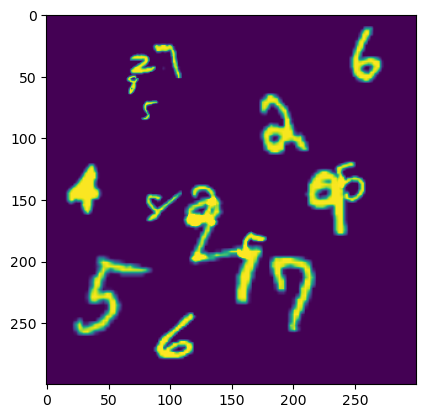

In [3]:
image = Image.open('/home/pqbas/dl/detection/MNIST-ObjectDetection/data/mnist_detection/test/images/0.png')
plt.imshow(image)
WIDTH, HEIGTH = image.size

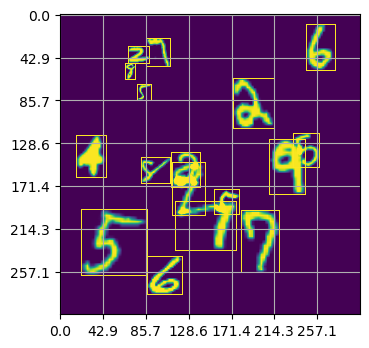

In [4]:
import matplotlib.ticker as plticker

part = 7

my_dpi=100
fig=plt.figure(figsize=(float(image.size[0])/my_dpi,float(image.size[1])/my_dpi),dpi=my_dpi)
ax=fig.add_subplot(111)
fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
ax.grid(which='major', axis='both', linestyle='-')

myInterval_x= WIDTH*1.0 / part
myInterval_y= HEIGTH*1.0 / part
loc_x = plticker.MultipleLocator(base=myInterval_x)
loc_y = plticker.MultipleLocator(base=myInterval_y)
ax.xaxis.set_major_locator(loc_x)
ax.yaxis.set_major_locator(loc_y)

draw = ImageDraw.Draw(image)
for xmin_,xmax_,ymin_,ymax_ in zip(xmin,xmax,ymin,ymax):
    draw.rectangle((xmin_,ymin_,xmax_,ymax_), outline='white')


ax.imshow(image)
plt.show()

In [5]:
# new_size = (224,224)

# xmax = xmax*(new_size[0]/WIDTH)
# xmin = xmin*(new_size[0]/WIDTH)
# ymin = xmin*(new_size[1]/HEIGTH)
# ymax = ymax*(new_size[1]/HEIGTH)

dW = WIDTH//7
dH = HEIGTH//7

n_objects = label.shape[0]
n_classes = 10

cx, cy = (xmin + xmax)//2, (ymin + ymax)//2

px, py = (cx % dW)/dW, (cy % dH)/dH
ph, pw = (xmax - xmin)/WIDTH, (ymax - ymin)/HEIGTH

class_prob = np.zeros((n_objects, n_classes), dtype=np.uint16)
class_prob[np.arange(n_objects), label] = 1

obj_score = np.ones(n_objects)


print("px:", list(px))
print("py:", list(py))
print("ph:", list(ph))
print("pw:", list(pw))
print("labels: \n",class_prob)
print("obj Score: ", obj_score)

px: [0.8571428571428571, 0.5952380952380952, 0.8571428571428571, 0.7380952380952381, 0.7619047619047619, 0.3333333333333333, 0.6666666666666666, 0.9761904761904762, 0.4523809523809524, 0.19047619047619047, 0.047619047619047616, 0.9523809523809523, 0.2619047619047619, 0.0, 0.47619047619047616, 0.2857142857142857, 0.40476190476190477]
py: [0.9523809523809523, 0.11904761904761904, 0.23809523809523808, 0.38095238095238093, 0.40476190476190477, 0.9047619047619048, 0.35714285714285715, 0.6904761904761905, 0.023809523809523808, 0.7857142857142857, 0.14285714285714285, 0.4523809523809524, 0.7142857142857143, 0.8571428571428571, 0.21428571428571427, 0.42857142857142855, 0.6190476190476191]
ph: [0.07, 0.13666666666666666, 0.08666666666666667, 0.1, 0.12666666666666668, 0.08, 0.03333333333333333, 0.09666666666666666, 0.20333333333333334, 0.09666666666666666, 0.11, 0.08333333333333333, 0.09666666666666666, 0.04666666666666667, 0.11666666666666667, 0.22, 0.12]
pw: [0.056666666666666664, 0.1666666666

In [6]:
dW = WIDTH//7
dH = HEIGTH//7

n_objects = cx.shape[0]
n_classes = 10

cx, cy = (xmin + xmax)//2, (ymin + ymax)//2
px, py = (cx % dW)/dW, (cy % dH)/dH
ph, pw = (xmax - xmin)/WIDTH, (ymax - ymin)/HEIGTH

boxes = np.stack(
            (px,py,ph,pw),
            axis= 1
        )


print('Grid:', 'x:', cx%7, 'y:', cy%7)
print('label', label)
print()

boxes = boxes.reshape(17,1,1,4)

matrix = np.zeros([n_objects,7,7])
matrix[np.arange(n_objects), cx%7, cy%7] = 1
matrix = matrix.reshape(17,7,7,1)
new_matrix = matrix * boxes
new_matrix_2 = new_matrix.sum(axis=0)

print(new_matrix_2.shape)

Grid: x: [1 4 1 3 4 0 0 6 5 1 2 5 4 0 6 5 3] y: [5 5 3 2 3 3 1 1 1 5 6 5 2 1 2 4 5]
label [2 2 5 4 7 7 8 2 7 6 9 5 8 5 6 5 9]

(7, 7, 4)


## Yolo Model

In [7]:
import os
import torchvision.transforms as T


DATA_PATH = 'data'
CLASSES_PATH = os.path.join(DATA_PATH, 'classes.json')

BATCH_SIZE = 64
EPOCHS = 135
WARMUP_EPOCHS = 0
LEARNING_RATE = 1E-4

EPSILON = 1E-6
IMAGE_SIZE = (448, 448)

S = 7       # Divide each image into a SxS grid
B = 2       # Number of bounding boxes to predict
C = 10      # Number of classes in the dataset

torch.Size([1, 7, 7, 20])


## Data loader

In [208]:
from dataloader import CustomImageDataset, DataLoader
from torchvision.transforms import Compose
import torchvision.transforms as transforms

transform = Compose([
    transforms.ToTensor(), # Scales data into [0,1]
    transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
])

dataset = CustomImageDataset(annotations_dir = '/home/pqbas/dl/detection/MNIST-ObjectDetection/data/mnist_detection/test/labels',
                             img_dir = '/home/pqbas/dl/detection/MNIST-ObjectDetection/data/mnist_detection/test/images',
                             data_transform = transform,
                             size=(448,448))

train_loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=dataset.collate_fn)


break_n = 0
for idx, (image, bbox,_) in enumerate(train_loader):
    print(image.shape)
    print(bbox.shape)
    if idx == break_n:
        break

torch.Size([1, 1, 448, 448])
torch.Size([1, 7, 7, 14])


target = [px,py,pw,ph,10-class-prob] -> 14 elements

output = [px1,py1,pw1,ph1,c1,px2,py2,pw2,ph2,c2, 10-class-prob] -> 20 elements

## Loss Function

In [10]:
import torch

image = torch.rand((1,1,448,448))
pred = model(image)


print(pred.shape)

torch.Size([1, 7, 7, 20])


torch.Size([1, 7, 7, 10])
torch.Size([1, 7, 7, 10])


In [253]:
def encontrar_coordenadas_sin_repeticiones(x, y):
    coordenadas = np.column_stack((x, y))  # Combine x and y into a single array
    coordenadas_sin_repeticiones = np.unique(coordenadas, axis=0)  # Find unique rows

    print(coordenadas_sin_repeticiones)

    # Separate the unique coordinates into x and y arrays
    x_sin_repeticiones = coordenadas_sin_repeticiones[:, 0]
    y_sin_repeticiones = coordenadas_sin_repeticiones[:, 1]

    return x_sin_repeticiones, y_sin_repeticiones

# Example usage
x = np.array([1, 5, 2, 5, 5, 5, 1, 3, 3, 2, 4, 2, 5, 3, 1])
y = np.array([1,1, 5, 1, 2, 5, 4, 2, 4, 1, 2, 5, 4, 6, 1])

x_sin_rep, y_sin_rep = encontrar_coordenadas_sin_repeticiones(x, y)
print("Coordenadas sin repeticiones:")
print("x:", x_sin_rep)
print("y:", y_sin_rep)

[[1 1]
 [1 4]
 [2 1]
 [2 5]
 [3 2]
 [3 4]
 [3 6]
 [4 2]
 [5 1]
 [5 2]
 [5 4]
 [5 5]]
Coordenadas sin repeticiones:
x: [1 1 2 2 3 3 3 4 5 5 5 5]
y: [1 4 1 5 2 4 6 2 1 2 4 5]


https://github.com/tanjeffreyz/yolo-v1/blob/main/config.py